### This exercise was performed on ARCC Beartooth with the following environment/software packages:

#### Load Preinstalled Modules:
module load gcc12.2.0 miniconda3 git/2.37.0

#### Create environment then activate with:
conda env create -f whatev_ml_env.yml
conda activate whatev_ml_env

#### Make sure jupyter can see the kernel in your conda env so you can select from southpass interface dropdown:
python -m ipykernel install --user --name=whatev_conda

#### Download data to folder and extract
wget https://archive.ics.uci.edu/static/public/186/wine+quality.zip
unzip wine+quality.zip


### In prior exercises, we performed exploratory data analysis and cleaned our data initially - now we will perform machine learning on the data which we've already cleaned.

## Hyperparameter Optimization: Directions

For this exercise, we will have a look at Hyperparameter Optimization --
instead of just choosing the best type of machine learning model, we also want
to choose the best hyperparameter setting for a task. The end result (i.e. the
predictive performance) is again not important; how you get there is.

Your deliverable will be a report, written in a style that it
would be suitable for inclusion in an academic paper as the "Experimental
Setup" section or similar. If unsure, check an academic paper of your choice,
for example [this one](https://www.eecs.uwyo.edu/~larsko/papers/pulatov_opening_2022-1.pdf). The
level of detail should be higher than in a typical academic paper though. Your
report should be at most five pages, including references and figures but
excluding appendices. It should have the following structure:
- Introduction: What problem are you solving, how are you going to solve it.
- Dataset Description: Describe the data you're using, e.g. how many features and observations, what are you predicting, any missing values, etc.
- Experimental Setup: What specifically are you doing to solve the problem, i.e.\ what programming languages and libraries, how are you processing the data, what machine learning algorithms are you considering and what hyperparameters and value ranges, what measures you are using to evaluate them, what hyperparameter optimization method you chose, etc.
- Results: Description of what you observed, including plots. Compare
  performance before and after tuning, and show the best configuration.
- Code: Add the code you've used as a separate file.

Your report must contain enough detail to reproduce what you did without the
code. If in doubt, include more detail.

There is no required format for the report. You could, for example, use an
iPython notebook.

## Data
We will have a look at the [Wine Quality
dataset](https://archive-beta.ics.uci.edu/dataset/186/wine+quality). Choose the
one that corresponds to your preference in wine. You may also use a dataset of
your choice, for example one that's relevant to your research.

Choose a small number of different machine learning algorithms and
hyperparameters, along with value ranges, for each. You can use implementations
of AutoML systems (e.g. auto-sklearn), scientific papers, or the documentation
of the library you are using to determine the hyperparameters to tune and the
value ranges. Note that there is not only a single way to do this, but define a
reasonable space (e.g. don't include whether to turn on debug output, or random
forests with 1,000,000 trees, or tune the loss function). Your hyperparameter
search space should be so large that you cannot simply run a grid search.

Determine the best machine learning algorithm and hyperparameter setting for
your dataset. Make sure to optimize both the type of machine learning algorithm
and the hyperparameters at the same time (do not first choose the best ML
algorithm and then optimize its hyperparameters). Choose a suitable
hyperparameter optimizer; you could also use several and e.g. compare the
results achieved by random search and Bayesian optimization. Make sure that the
way you evaluate model performance avoids bias and overfitting. You could use
statistical tests to make this determination.

## Submission
Add your report and code to this repository. Bonus points if you can set up a Github action to automatically run the code and generate the report!

## Introduction: 

What problem are you solving, how are you going to solve it. Dataset Description: Describe the data you're using, e.g. how many features and observations, what are you predicting, any missing values, etc.

### What problem we're solving: 


### Data Information: 


In [247]:
#importing all necessary libraries
import os,sys,platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as torch
import seaborn as sb
import sklearn as sk
from copy import deepcopy as copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Different sklearn model types
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

#For searching through possible hyperparameters
from sklearn.model_selection import GridSearchCV, cross_val_score

#To create classifications
from sklearn.datasets import make_classification

from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay as showMatrix
from sklearn.metrics import roc_auc_score

from IPython.display import Image



In [195]:
#confirm and checking platform and sotware versions in software stack
print(f"Python Platform:{platform.platform()}")
print(f"Python {sys.version}")
print(f"PyTorch Version: ", torch.__version__)
print(f"Pandas Version: " , pd.__version__)
print(f"SkLearn Version: " , sk. __version__)

Python Platform:macOS-14.0-arm64-arm-64bit
Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
PyTorch Version:  2.1.1
Pandas Version:  2.1.4
SkLearn Version:  1.3.0


In [196]:
#checking devices available,though I know this is unfortunately not usable here, I always include it in my code 
#So I can know what the run can "see"

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
# print the names
for i in available_gpus:
    print(torch.cuda.get_device_properties(i).name)

# Prints 'Tesla V100-SXM2-16GB', for example
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() or torch.backends.mps.is_available() else 'cpu')
print("Using device: ", device)

None
Using device:  cuda


In [197]:
#Class to display pdfs as embedded pdf within iframe - we'll need it to display the final paper.

class PDF(object):
  def __init__(self, pdf, size=(800,1200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)


In [198]:
#Make sure we're pointing at the right directory in relation to where we are.
print(os.getcwd())

#Import data and separate out
whitewinedataraw = pd.read_csv("winequality-white.csv",sep=';')
redwinedataraw = pd.read_csv("winequality-red.csv", sep=';')

#view raw data, get info about it, clean if necessary
whitewinedataraw.info() #information about range
whitewinedataraw.describe() #Description of features
whitewinedataraw.duplicated() #Do we have any duplicate values in our data?
cat_col = [col for col in whitewinedataraw.columns if whitewinedataraw[col].dtype=='object']
num_col = [col for col in whitewinedataraw.columns if whitewinedataraw[col].dtype!='object']
print("Categorical columns: ", cat_col)
print("Numerical columns: ", num_col)

redwinedataraw.info()
redwinedataraw.describe()
redwinedataraw.duplicated()
cat_col = [col for col in redwinedataraw.columns if redwinedataraw[col].dtype=='object']
num_col = [col for col in redwinedataraw.columns if redwinedataraw[col].dtype!='object']
print("Categorical columns: ", cat_col)
print("Numerical columns: ", num_col)

/Users/lisa/Documents/GitHub/hyperparameter-optimization-lrstafford
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB
Categorical columns:  []
Numerical columns:  ['fixed acidi

In [199]:
whitewinedata = whitewinedataraw.copy()
whitewinelabels = whitewinedata.pop('quality')
display(whitewinelabels)

redwinedata = redwinedataraw.copy()
redwinelabels = redwinedata.pop('quality')
display(redwinelabels)

0       6
1       6
2       6
3       6
4       6
       ..
4893    6
4894    5
4895    6
4896    7
4897    6
Name: quality, Length: 4898, dtype: int64

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

Because Standard Scaling worked best in the last exercise, we apply the same data transformation on the dataset again, in this exercise.  Code copied from Exploratory Data Analysis repo: https://github.com/COSC5557/exploratory-data-analysis-lrstafford/blob/main/wine_data.ipynb 




In [200]:
#Transform and scale our data and pull out labels

transredwinedata = redwinedataraw.copy()
transwhitewinedata = whitewinedataraw.copy()
whitewinelabels = transwhitewinedata.pop('quality')
redwinelabels = transredwinedata.pop('quality')

scaledred = StandardScaler().fit_transform(transredwinedata)
scaledwhite = StandardScaler().fit_transform(transwhitewinedata)


We'll be defining classes for each ML algorithm in the next couple sections:

1. Kmeans Clustering: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
2. Support Vector Machine
    1. Linear: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
    2. Classic: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
3. KNeighbor Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
4. SGD Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
5. Neural Network: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network

In [201]:
#Set up initial classifications 
def classify(data,labels):
    data, labels = make_classification(n_features=11,n_classes = 7, random_state=0)

In [202]:
#Make an empty pandas dataframe in which to store model performance data:
performance_scores = pd.DataFrame(columns=['Model_Type',
                                           'Wine_Type', 
                                           'Training_Score', 
                                           'Test_Score'])

display(performance_scores)

,Model_Type,Wine_Type,Training_Score,Test_Score


In [ ]:
#Define list of models to evaluate
models = {
    ['knn', 'KNeighborsClassifier()'],
    ['sgd', 'SGDClassifier()'],
    ['mlpc', 'MLPClassifier()']}

In [ ]:
#Define knn hyperparameters from which to optimize
knnparams = {
    'n_neighbors': [5, 10, 25, 50], 
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree'],
    'n_jobs': [-1]
}

In [203]:
#Define K-nearest neighbor grid search function
def knn_gs(data,labels,winetype):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=.8, shuffle=True, random_state=0)
    X_train.shape, X_test.shape
    knn = KNeighborsClassifier() 
    kneighbor = GridSearchCV(knn, knnparams)

    kneighbor.fit(X_train, y_train)
    
    trainpred = kneighbor.predict(X_train)
    testpred = kneighbor.predict(X_test)
    
    trainacc = accuracy_score(trainpred, y_train)
    testacc = accuracy_score(testpred, y_test)
    
    #import scoring into dataframe
    performance_scores.loc[len(performance_scores)] = ['K-Nearest Neighbor', winetype, trainacc, testacc]
    
    print("Accuracy of KNN on", winetype, "training is:", trainacc)
    print("Accuracy of KNN on", winetype, "test data is:", testacc)

    winematrix = cm(y_test, testpred)
    disp=showMatrix(winematrix, display_labels=[3,4,5,6,7,8])
    disp.plot()
    plt.show()
    
    display(pd.DataFrame(kneighbor.cv_results_))
    
    return trainacc, testacc


In [ ]:
#Define evolutionary method to optimize hyperparameter selection 
def knn_evol(data, labels, winetype, hyperparams):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=.8, shuffle=True, random_state=0)
    
    #def ML model based on set of hyperparams
    knn = KNeighborsClassifier(hyperparams) 
    
    #Train
    knn.fit(X_train, y_train)
    
    #Make a prediction space then eval that space
    pred = knn.predict(X_test)
    evol = np.sqrt(np.mean(np.square(pred-y_test)))
    
    return evol

In [ ]:
#define functions to help with hyperparam selection using baysian optimization
def internal_opt(hyperparams):
    #given hyperparams list to optimize for.
    
def costf():
    
    return c

def aquisf():
    return u

def predmod():
    return c_hat



In [ ]:
#define our bayesian optimization model selection

def knn_bo(data,labels,winetype):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=.8, shuffle=True, random_state=0)
    X_train.shape, X_test.shape
    knn = KNeighborsClassifier() 

In [ ]:
#Define set of hyperparams to search through 
sgdparams = [
    { #logistic regression SVM
        'loss': ['log_loss'], 'penalty': ['l1','l2', 'elasticnet'],
        'alpha': [0.001, 0.0001, 0.00005],
        'fit_intercept': [True],
        'max_iter': [2000],
        'tol': [1e-3, 1e-4, 1e-5],
        'early_stopping': [True],
        'n_jobs': [-1]
    },
    { #Smooth loss tolerating outliers
        'loss': ['modified_huber'], 'penalty': ['l1','l2','elasticnet'],
        'epsilon': [0.05, 0.1, 0.5, 1, 10],
        'fit_intercept': [True],
        'max_iter': [2000],
        'tol': [1e-3, 1e-4, 1e-5],
        'early_stopping': [True],
        'n_jobs': [-1]
    },
    { #Perceptron
        'loss': ['perceptron'], 'penalty': ['l1','l2','elasticnet'],
        'fit_intercept': [True],
        'max_iter': [2000],
        'tol': [1e-3, 1e-4, 1e-5],
        'early_stopping': [True],
        'n_jobs': [-1]
    }  
]

In [256]:
#Define function for grid search
def sgd_gs(data,labels,winetype):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=.8, shuffle=True, random_state=0)
    X_train.shape, X_test.shape
    print(np.unique(y_train), np.unique(y_test))
    sgd = SGDClassifier() 
    sgdclass = GridSearchCV(sgd, sgdparams, refit=True)
    sgdclass.fit(X_train, y_train)
    
    trainpred = sgdclass.predict(X_train)
    testpred = sgdclass.predict(X_test)
    
    trainacc = accuracy_score(trainpred, y_train)
    testacc = accuracy_score(testpred, y_test)
    
    #import scoring into dataframe
    performance_scores.loc[len(performance_scores)] = ['SGD Classifier', winetype, trainacc, testacc]
    
    print("Accuracy SGD Classifier on", winetype, "training is:", trainacc)
    print("Accuracy of SGD Classifier on", winetype, "test data is:", testacc)

    winematrix = cm(y_test, testpred)
    disp=showMatrix(winematrix, display_labels=[3,4,5,6,7,8])
    disp.plot()
    plt.show()
    
    display(pd.DataFrame(sgdclass.cv_results_))
    
    return trainacc, testacc

In [ ]:
#define set of mlp hyperparams to search through
mlpparams = [
    { 
        #'hidden_layer_sizes': [[11,100,5], [11,25,4]],
        'activation': ['identity', 'logistic', 'tanh' 'relu'],
        'solver': ['adam'],
        'alpha': [0.001, 0.0001, 0.00001],
        'max_iter': [1000],
        'tol': [1e-3,1e-4,1e-5],
        'early_stopping': [True],
    },
    { 
        #'hidden_layer_sizes': [[11,100,5], [11,25,4]],
        'activation': ['identity', 'logistic', 'relu'],
        'solver': ['sgd'],
        'momentum': [0.9, 0.95, 0.99],
        'alpha': [0.001, 0.0001, 0.00001],
        'max_iter': [1000],
        'tol': [1e-3,1e-4,1e-5],
        'early_stopping': [True],
    },
    {    #'hidden_layer_sizes': [[11,100,5], [11,25,4]],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs'],
        'dual': [True],
        'momentum': [0.9, 0.95, 0.99],
        'alpha': [0.001, 0.0001, 0.00001],
        'max_iter': [2000],
        'tol': [1e-3,1e-4,1e-5],
        'early_stopping': [True],
    }
    
]

In [262]:
#Define grid search function for mlp hyperparam optimization
def mlp_gs(data,labels,winetype):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=.8, shuffle=True, random_state=0)
    X_train.shape, X_test.shape
    mlpc = MLPClassifier() 
    mlpclass = GridSearchCV(mlpc, mlpparams)
    mlpclass.fit(X_train, y_train)
    trainpred = mlpclass.predict(X_train)
    testpred = mlpclass.predict(X_test)
    
    trainacc = accuracy_score(trainpred, y_train)
    testacc = accuracy_score(testpred, y_test)
    
    #import scoring into dataframe
    performance_scores.loc[len(performance_scores)] = ['MultiLayer Perceptron', winetype, trainacc, testacc]
    
    print("Accuracy MLP NN Classifier on", winetype, "training is:", trainacc)
    print("Accuracy of MLP NN Classifier on", winetype, "test data is:", testacc)

    winematrix = cm(y_test, testpred)
    disp=showMatrix(winematrix, display_labels=[3,4,5,6,7,8])
    disp.plot()
    plt.show()
    
    display(pd.DataFrame(mlpclass.cv_results_))
    
    return testacc

Accuracy of KNN on white training is: 1.0
Accuracy of KNN on white test data is: 0.5724489795918367


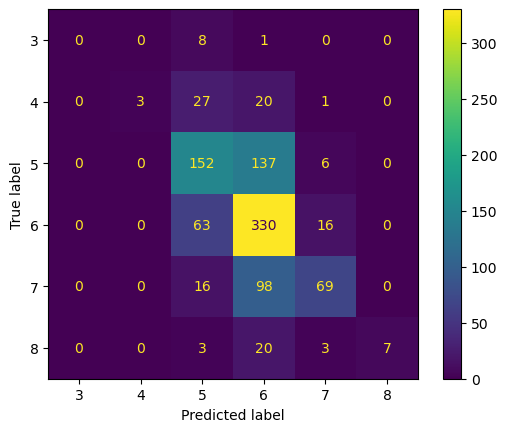

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002131,0.001060,0.023429,0.007299,ball_tree,-1,5,uniform,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.483418,0.473214,0.489796,0.501916,0.480204,0.485710,0.009706,9
1,0.001289,0.000036,0.007706,0.000931,ball_tree,-1,5,distance,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.573980,0.565051,0.554847,0.607918,0.586207,0.577601,0.018339,7
2,0.001316,0.000038,0.019274,0.001537,ball_tree,-1,10,uniform,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.470663,0.470663,0.448980,0.505747,0.464879,0.472186,0.018563,15
3,0.001297,0.000049,0.008330,0.000684,ball_tree,-1,10,distance,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.596939,0.572704,0.557398,0.628352,0.586207,0.588320,0.024006,5
4,0.001378,0.000083,0.020745,0.001902,ball_tree,-1,25,uniform,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.474490,0.484694,0.471939,0.491699,0.466156,0.477795,0.009183,11
5,0.001249,0.000029,0.011829,0.001040,ball_tree,-1,25,distance,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.604592,0.596939,0.586735,0.638570,0.593870,0.604141,0.018143,3
6,0.001362,0.000066,0.022270,0.000951,ball_tree,-1,50,uniform,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.474490,0.480867,0.466837,0.490421,0.466156,0.475754,0.009105,13
7,0.001295,0.000032,0.011241,0.001230,ball_tree,-1,50,distance,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.613520,0.602041,0.580357,0.639847,0.598978,0.606949,0.019597,1
8,0.001251,0.000026,0.015604,0.000561,kd_tree,-1,5,uniform,"{'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neig...",0.483418,0.473214,0.489796,0.501916,0.480204,0.485710,0.009706,9
9,0.001324,0.000083,0.007475,0.000636,kd_tree,-1,5,distance,"{'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neig...",0.573980,0.565051,0.554847,0.607918,0.586207,0.577601,0.018339,7


Accuracy of KNN on red training is: 1.0
Accuracy of KNN on red test data is: 0.640625


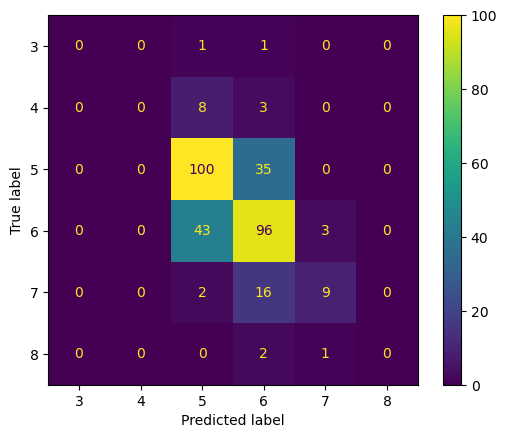

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000867,0.000044,0.008537,0.000629,ball_tree,-1,5,uniform,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.437500,0.554688,0.496094,0.484375,0.490196,0.492570,0.037354,15
1,0.000807,0.000015,0.004784,0.000164,ball_tree,-1,5,distance,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.519531,0.574219,0.589844,0.578125,0.556863,0.563716,0.024494,7
2,0.000836,0.000061,0.070636,0.122066,ball_tree,-1,10,uniform,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.468750,0.539062,0.500000,0.488281,0.482353,0.495689,0.023909,13
3,0.000812,0.000040,0.004605,0.000172,ball_tree,-1,10,distance,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.531250,0.609375,0.605469,0.582031,0.592157,0.584056,0.028135,5
4,0.000778,0.000024,0.007899,0.000408,ball_tree,-1,25,uniform,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.480469,0.515625,0.523438,0.496094,0.525490,0.508223,0.017331,9
5,0.000797,0.000019,0.004852,0.000180,ball_tree,-1,25,distance,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.554688,0.601562,0.640625,0.578125,0.600000,0.595000,0.028494,3
6,0.000779,0.000034,0.008050,0.000373,ball_tree,-1,50,uniform,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.511719,0.507812,0.472656,0.500000,0.501961,0.498830,0.013733,11
7,0.000794,0.000027,0.005303,0.000431,ball_tree,-1,50,distance,"{'algorithm': 'ball_tree', 'n_jobs': -1, 'n_ne...",0.578125,0.597656,0.640625,0.585938,0.600000,0.600469,0.021592,1
8,0.000744,0.000013,0.007575,0.000212,kd_tree,-1,5,uniform,"{'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neig...",0.437500,0.554688,0.496094,0.484375,0.490196,0.492570,0.037354,15
9,0.000774,0.000025,0.004637,0.000152,kd_tree,-1,5,distance,"{'algorithm': 'kd_tree', 'n_jobs': -1, 'n_neig...",0.519531,0.574219,0.589844,0.578125,0.556863,0.563716,0.024494,7


(1.0, 0.640625)

In [258]:
knn_gs(whitewinedata, whitewinelabels, "white")
knn_gs(redwinedata, redwinelabels, "red")

[3 4 5 6 7 8 9] [3 4 5 6 7 8]
Accuracy SGD Classifier on white training is: 0.45661051556916793
Accuracy of SGD Classifier on white test data is: 0.4173469387755102


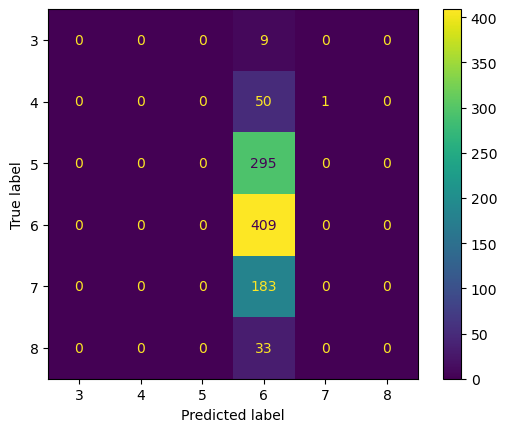

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_early_stopping,param_fit_intercept,param_loss,param_max_iter,param_n_jobs,...,param_epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023712,0.008369,0.000855,0.000218,0.001,True,True,log_loss,2000,-1,...,NaN,"{'alpha': 0.001, 'early_stopping': True, 'fit_...",0.459184,0.286990,0.433673,0.459770,0.385696,0.405063,0.064895,16
1,0.019605,0.000500,0.000736,0.000116,0.001,True,True,log_loss,2000,-1,...,NaN,"{'alpha': 0.001, 'early_stopping': True, 'fit_...",0.478316,0.465561,0.460459,0.340996,0.411239,0.431314,0.050580,7
2,0.018619,0.000670,0.000700,0.000078,0.001,True,True,log_loss,2000,-1,...,NaN,"{'alpha': 0.001, 'early_stopping': True, 'fit_...",0.489796,0.283163,0.410714,0.320562,0.459770,0.392801,0.079313,23
3,0.017040,0.001403,0.000742,0.000080,0.001,True,True,log_loss,2000,-1,...,NaN,"{'alpha': 0.001, 'early_stopping': True, 'fit_...",0.179847,0.297194,0.357143,0.038314,0.459770,0.266454,0.145663,77
4,0.016122,0.000538,0.000719,0.000087,0.001,True,True,log_loss,2000,-1,...,NaN,"{'alpha': 0.001, 'early_stopping': True, 'fit_...",0.451531,0.168367,0.456633,0.329502,0.457216,0.372650,0.113155,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.016210,0.000537,0.000657,0.000021,NaN,True,True,perceptron,2000,-1,...,NaN,"{'early_stopping': True, 'fit_intercept': True...",0.464286,0.455357,0.456633,0.457216,0.457216,0.458141,0.003146,1
77,0.016421,0.000366,0.000663,0.000032,NaN,True,True,perceptron,2000,-1,...,NaN,"{'early_stopping': True, 'fit_intercept': True...",0.331633,0.316327,0.355867,0.445722,0.227331,0.335376,0.070209,57
78,0.017484,0.001092,0.000681,0.000029,NaN,True,True,perceptron,2000,-1,...,NaN,"{'early_stopping': True, 'fit_intercept': True...",0.179847,0.293367,0.459184,0.296296,0.288633,0.303466,0.089334,65
79,0.016926,0.000900,0.000688,0.000068,NaN,True,True,perceptron,2000,-1,...,NaN,"{'early_stopping': True, 'fit_intercept': True...",0.456633,0.340561,0.288265,0.291188,0.330779,0.341485,0.061215,51


[3 4 5 6 7 8] [3 4 5 6 7 8]
Accuracy SGD Classifier on red training is: 0.4354964816262705
Accuracy of SGD Classifier on red test data is: 0.378125


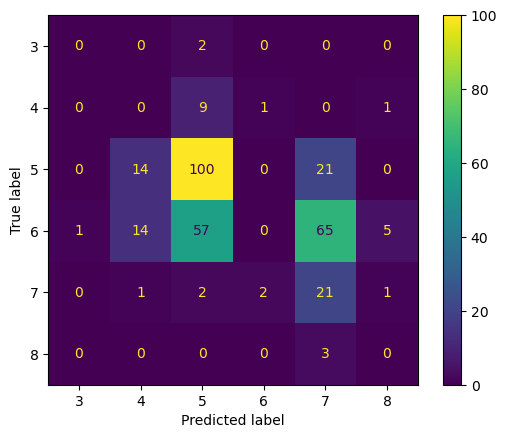

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_early_stopping,param_fit_intercept,param_loss,param_max_iter,param_n_jobs,...,param_epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028043,0.010211,0.001021,0.000480,0.001,True,True,log_loss,2000,-1,...,NaN,"{'alpha': 0.001, 'early_stopping': True, 'fit_...",0.460938,0.492188,0.449219,0.492188,0.454902,0.469887,0.018582,5
1,0.014006,0.001097,0.000592,0.000040,0.001,True,True,log_loss,2000,-1,...,NaN,"{'alpha': 0.001, 'early_stopping': True, 'fit_...",0.492188,0.523438,0.410156,0.492188,0.470588,0.477711,0.037748,2
2,0.013331,0.000941,0.000560,0.000019,0.001,True,True,log_loss,2000,-1,...,NaN,"{'alpha': 0.001, 'early_stopping': True, 'fit_...",0.382812,0.421875,0.390625,0.312500,0.282353,0.358033,0.052063,58
3,0.013328,0.001161,0.000588,0.000039,0.001,True,True,log_loss,2000,-1,...,NaN,"{'alpha': 0.001, 'early_stopping': True, 'fit_...",0.347656,0.441406,0.433594,0.312500,0.431373,0.393306,0.052914,37
4,0.013393,0.000337,0.000577,0.000043,0.001,True,True,log_loss,2000,-1,...,NaN,"{'alpha': 0.001, 'early_stopping': True, 'fit_...",0.417969,0.433594,0.406250,0.421875,0.200000,0.375937,0.088401,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.012656,0.000628,0.000542,0.000036,NaN,True,True,perceptron,2000,-1,...,NaN,"{'early_stopping': True, 'fit_intercept': True...",0.445312,0.507812,0.453125,0.441406,0.482353,0.466002,0.025355,8
77,0.013484,0.000915,0.000597,0.000040,NaN,True,True,perceptron,2000,-1,...,NaN,"{'early_stopping': True, 'fit_intercept': True...",0.429688,0.398438,0.457031,0.492188,0.443137,0.444096,0.030898,17
78,0.013664,0.000786,0.000599,0.000038,NaN,True,True,perceptron,2000,-1,...,NaN,"{'early_stopping': True, 'fit_intercept': True...",0.382812,0.281250,0.375000,0.386719,0.501961,0.385548,0.070072,39
79,0.013123,0.000864,0.000563,0.000006,NaN,True,True,perceptron,2000,-1,...,NaN,"{'early_stopping': True, 'fit_intercept': True...",0.347656,0.132812,0.363281,0.476562,0.505882,0.365239,0.131536,52


(0.4354964816262705, 0.378125)

In [260]:
sgd_gs(whitewinedata, whitewinelabels, "white")
sgd_gs(redwinedata, redwinelabels, "red")

In [ ]:
mlp_gs(whitewinedata, whitewinelabels, "white")
mlp_gs(redwinedata, redwinelabels, "red")

In [43]:
#Define a function to give us a list of scores specific to one model and winetype
def splitscoreswine(model, winetype):
    modelscore = performance_scores[performance_scores['Model_Type']== model]
    scores = modelscore[modelscore['Wine_Type'] == winetype]
    return scores

#Define a function to give us a list of scores specific to one model
def splitscores(model):
    score = performance_scores[performance_scores['Model_Type']== model]
    return scores


In [44]:
mlp_white_scores = splitscoreswine('MultiLayer Perceptron', 'white')
mlp_red_scores = splitscoreswine('MultiLayer Perceptron', 'red')
sgd_white_scores = splitscoreswine('SGD Classifier', 'white')
sgd_red_scores = splitscoreswine('SGD Classifier', 'red')

### All the scores for iterations are the same each run, except for SGD and MLP, so we need to average that out, while simply getting the first score in the score list that meets each requirements for the others.  

In [45]:
ave_mlp_white_train = mlp_white_scores.loc[:, 'Training_Score'].mean()
ave_mlp_white_test = mlp_white_scores.loc[:, 'Test_Score'].mean()
ave_mlp_red_train = mlp_red_scores.loc[:, 'Training_Score'].mean()
ave_mlp_red_test = mlp_red_scores.loc[:, 'Test_Score'].mean()

ave_sgd_white_train = sgd_white_scores.loc[:, 'Training_Score'].mean()
ave_sgd_white_test = sgd_white_scores.loc[:, 'Test_Score'].mean()
ave_sgd_red_train = sgd_red_scores.loc[:, 'Training_Score'].mean()
ave_sgd_red_test = sgd_red_scores.loc[:, 'Test_Score'].mean()

In [ ]:
print(ave_mlp_white_train)
print(ave_mlp_white_test)
print(ave_mlp_red_train)
print(ave_mlp_red_test)

In [46]:
#Make a pandas dataframe in which to store average model performance data:
average_scores = pd.DataFrame(columns=['Model_Type', 
                                           'White_Training_Score', 
                                           'White_Test_Score',
                                           'Red_Training_Score',
                                           'Red_Test_Score'])

def getrow(model, wine):
    get_row = performance_scores[
        (performance_scores.Model_Type == model) &
        (performance_scores.Wine_Type == wine)].iloc[0]
    return get_row

average_scores.loc[len(average_scores)] = ['K-Nearest Neighbor', 
                                           getrow('K-Nearest Neighbor', 'white')['Training_Score'],
                                           getrow('K-Nearest Neighbor', 'white')['Test_Score'],
                                           getrow('K-Nearest Neighbor', 'red')['Training_Score'],
                                           getrow('K-Nearest Neighbor', 'red')['Test_Score']]

average_scores.loc[len(average_scores)] = ['SGD Classifier',
                                           ave_sgd_white_train,
                                           ave_sgd_white_test,
                                           ave_mlp_red_train,
                                           ave_mlp_red_test
                                          ]

average_scores.loc[len(average_scores)] = ['MultiLayer Perceptron', 
                                           ave_mlp_white_train,
                                           ave_mlp_white_test,
                                           ave_mlp_red_train,
                                           ave_mlp_red_test]

In [47]:
display(average_scores)

,Model_Type,White_Training_Score,White_Test_Score,Red_Training_Score,Red_Test_Score
0,K-Nearest Neighbor,1.000000,0.580612,1.000000,0.618750
1,SGD Classifier,0.429109,0.408418,0.591243,0.595625
2,MultiLayer Perceptron,0.515875,0.462653,0.591243,0.595625


In [ ]:
#Report:  
PDF('Exercise4.pdf',size=(800,1200))